# Download required package

In [1]:
#@title
!git clone https://github.com/mchong6/SOAT.git
%cd SOAT
!pip install tqdm gdown scikit-learn scipy lpips opencv-python kornia
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'SOAT'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 179 (delta 50), reused 135 (delta 23), pack-reused 0
Receiving objects: 100% (179/179), 63.54 MiB | 4.13 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/SOAT
     |████████████████████████████████| 53 kB 1.3 MB/s 
     |████████████████████████████████| 367 kB 5.8 MB/s 
Cloning into 'models'...
remote: Enumerating objects: 3069, done.
remote: Counting objects: 100% (3069/3069), done.
remote: Compressing objects: 100% (2599/2599), done.
remote: Total 3069 (delta 762), reused 1355 (delta 428), pack-reused 0
Receiving objects: 100% (3069/3069), 33.30 MiB | 24.69 MiB/s, done.
Resolving deltas: 100% (762/762), done.


In [2]:
#@title
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install -q .

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
#@title imports

import os
import torch
import torchvision
from torch import nn
import numpy as np
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
from model import *
from tqdm import tqdm as tqdm
import pickle
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore", category=UserWarning) # get rid of interpolation warning
import kornia.filters as k
from torchvision.utils import save_image
from util import *
import scipy

from google.colab import output
output.enable_custom_widget_manager()
from object_detection.utils import colab_utils
%matplotlib inline

generator = Generator(256, 512, 8, channel_multiplier=2).cuda().eval()
truncation = 0.7

# Panorama Generation
Generate a panorama using a pretrained stylegan by stitching intermediate activations.

Downloading...
From: https://drive.google.com/uc?id=1rN5EhwiY95BBNPvOezhX4SZ_tEOR0qe2
To: /content/SOAT/landscape.pt
100%|██████████| 829M/829M [00:10<00:00, 78.1MB/s]


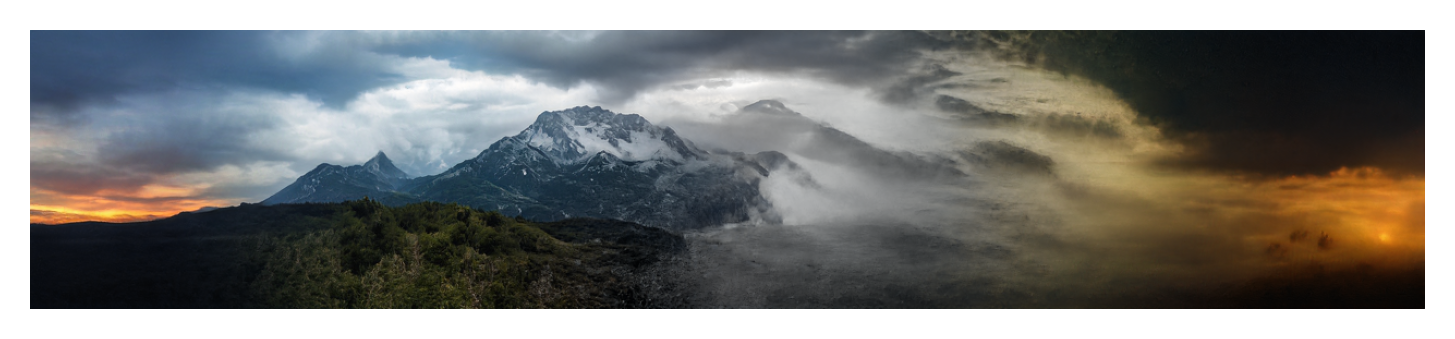

In [4]:
model_type = 'landscape' #@param ['church', 'face', 'landscape']
num_im =  5#@param {type:"number"}
random_seed =  90#@param {type:"number"}

plt.rcParams['figure.dpi'] = 300

mean_latent = load_model(generator, f'{model_type}.pt')

# pad determines how much of an image is involve in the blending
pad = 512//4

all_im = []

random_state = np.random.RandomState(random_seed)

# latent smoothing
with torch.no_grad():
    z = random_state.randn(num_im, 512).astype(np.float32)
    z = scipy.ndimage.gaussian_filter(z, [.7, 0], mode='wrap')
    z /= np.sqrt(np.mean(np.square(z)))
    z = torch.from_numpy(z).cuda()

    source = generator.get_latent(z, truncation=truncation, mean_latent=mean_latent)
        
    # merge images 2 at a time
    for i in range(num_im-1):
        source1 = index_layers(source, i)
        source2 = index_layers(source, i+1)
        all_im.append(generator.merge_extension(source1, source2))

# display intermediate generations    
# for i in all_im:
#     display_image(i)
    

b,c,h,w = all_im[0].shape
panorama_im = torch.zeros(b,c,h,512+(num_im-2)*256)

# We created a series of 2-blended images which we can overlay to form a large panorama
# add first image
coord = 256+pad
panorama_im[..., :coord] = all_im[0][..., :coord]

for im in all_im[1:]:
    panorama_im[..., coord:coord+512-2*pad] = im[..., pad:-pad]
    coord += 512-2*pad
panorama_im[..., coord:] = all_im[-1][..., 512-pad:]

display_image(panorama_im)

# Generation from a single image
Make the image bigger by adding padding or resizing the intermediate activations of stylegan. <br>
reflect, replicate, circular are padding options<br>
horizontal, vertical resizes the activations to stretch the image in a realistic manner

Downloading...
From: https://drive.google.com/uc?id=1ORsZHZEeFNEX9HtqRutt1jMgrf5Gpcat
To: /content/SOAT/church.pt
100%|██████████| 121M/121M [00:04<00:00, 25.7MB/s]


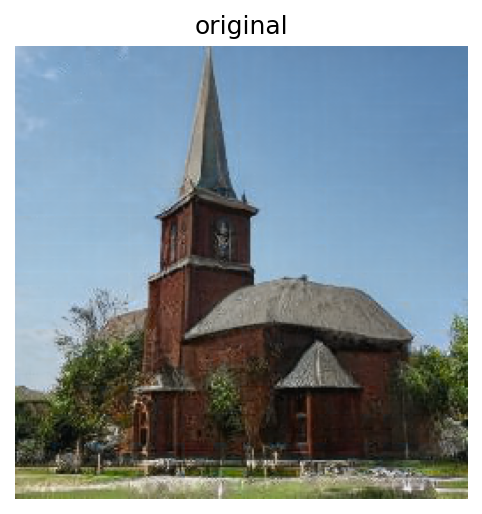

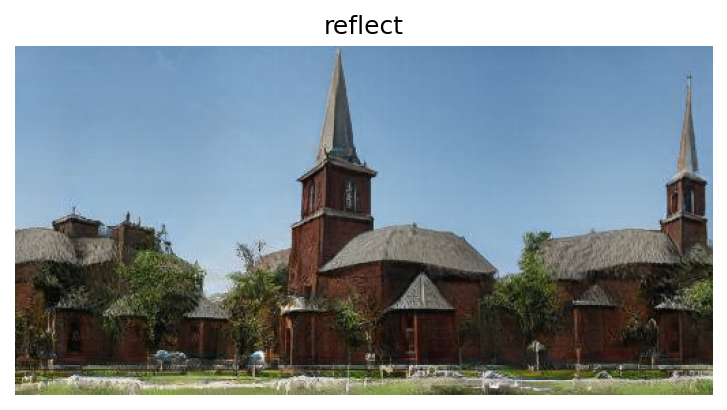

In [5]:
mode = 'reflect' #@param ['reflect', 'replicate', 'circular', 'horizontal', 'vertical']
model_type = 'church' #@param ['church', 'face', 'landscape']
random_seed =  12353#@param {type:"number"}


plt.rcParams['figure.dpi'] = 150
torch.manual_seed(random_seed)

mean_latent = load_model(generator, f'{model_type}.pt')

with torch.no_grad():
    code = torch.randn([1, 512]).cuda()
    latent = generator.get_latent(code, truncation=truncation, mean_latent=mean_latent)

    source_im,_ = generator(latent)

    display_image(source_im, size=None, title='original')

    source_im = generator.singan(latent, mode)
    display_image(source_im, size=None, title=mode)

# Merging 2 images
Generate 2 images and seamlessly blend them to merge them

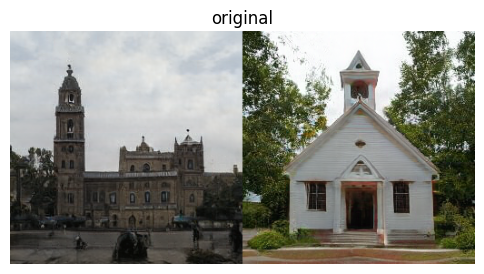

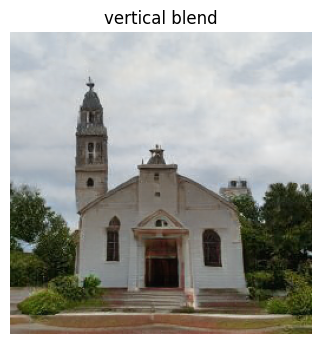

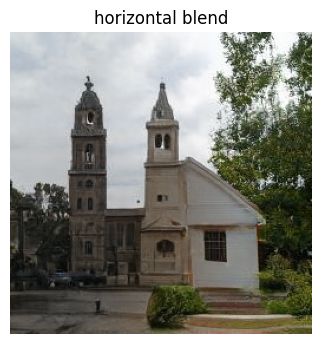

In [6]:
model_type = 'church' #@param ['church', 'face', 'landscape']
random_seed =  45612#@param {type:"number"}

plt.rcParams['figure.dpi'] = 100
torch.manual_seed(random_seed)

mean_latent = load_model(generator, f'{model_type}.pt')

with torch.no_grad():
    code = torch.randn([1, 512]).cuda()
    code2 = torch.randn([1,512]).cuda()

    source = generator.get_latent(code, truncation=truncation, mean_latent=mean_latent)
    source2 = generator.get_latent(code2, truncation=truncation, mean_latent=mean_latent)
    
    source_im, _ = generator(source)
    target_im, _ = generator(source2)
    display_image(torch.cat([source_im, target_im], -1), size=None, title='original')

    vertical_im = generator.blend(source, source2, 'vertical')
    display_image(vertical_im, title='vertical blend')

    horizontal_im = generator.blend(source, source2, 'horizontal')
    display_image(horizontal_im, title='horizontal blend')

# Transfer features from image to image using bbox

1) Generate source and target images <br>
2) Draw bounding box of feature you wish to transfer on source face <br>
3) Corresponding feature from target face will be transferred over.

Downloading...
From: https://drive.google.com/uc?id=1dOBo4xWUwM7-BwHWZgp-kV1upaD6tHAh
To: /content/SOAT/face.pt
100%|██████████| 827M/827M [00:12<00:00, 67.0MB/s]


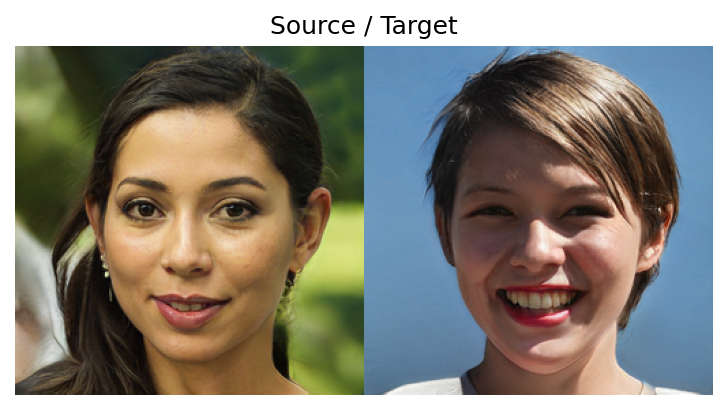

In [7]:
model_type = 'face' #@param ['church', 'face', 'landscape']
random_seed =  428290#@param {type:"number"}


plt.rcParams['figure.dpi'] = 150
torch.manual_seed(random_seed)

mean_latent = load_model(generator, f'{model_type}.pt')

with torch.no_grad():
    code = torch.randn([1, 512]).cuda()
    code2 = torch.randn([1,512]).cuda()

    source = generator.get_latent(code, truncation=truncation, mean_latent=mean_latent)
    source2 = generator.get_latent(code2, truncation=truncation, mean_latent=mean_latent)
    
    source_im, _ = generator(source)
    target_im, _ = generator(source2)
    display_image(torch.cat([source_im, target_im], -1), size=None, title='Source / Target')

Draw a bounding box over the feature you would like to transfer from target image. The source and target images do not need to be aligned. Click **submit** after.

In [8]:
boxes = []
colab_utils.annotate([tensor2bbox_im(source_im)], box_storage_pointer=boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

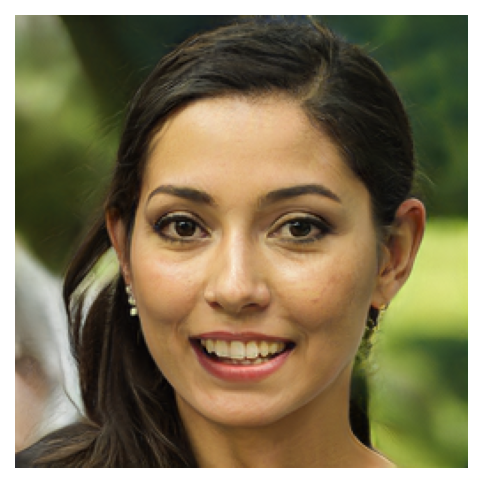

In [9]:
#@markdown num_swap determines how many layers to copy from reference image. The more copied layers, the more accurate the feature transfer. However, too large will cause artifacts.
num_swap =  9#@param {type:"slider", min:0, max:20, step:1}

with torch.no_grad():
    blend = generator.blend_bbox(source, source2, prepare_bbox(boxes), model_type=model_type, num_blend=num_swap) # for face
    display_image(blend)

#Controllable Toonification

In [10]:
#@title Load face and disney models
# Load generator. Generator 1 should be face, Generator 2 should be disney
generator2 = Generator(256, 512, 8, channel_multiplier=2).cuda().eval()

mean_latent1 = load_model(generator, 'face.pt')
mean_latent2 = load_model(generator2, 'disney.pt')

truncation = .5

Downloading...
From: https://drive.google.com/uc?id=1n2uQ5s2XdUBGIcZA9Uabz1mkjVvKWFeG
To: /content/SOAT/disney.pt
100%|██████████| 812M/812M [00:14<00:00, 56.7MB/s]


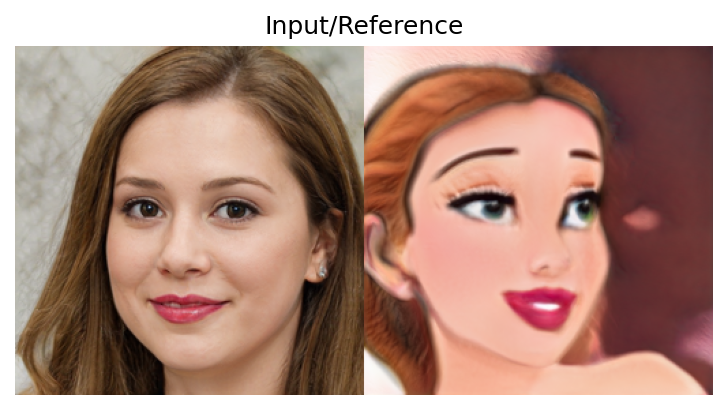

In [11]:
#@title load source face and generate reference image
face_seed =  19261#@param {type:"number"} 
disney_seed =  20131#@param {type:"number"} 

    
with torch.no_grad():
    torch.manual_seed(face_seed)
    source_code = torch.randn([1, 512]).cuda()
    latent1 = generator2.get_latent(source_code, truncation=truncation, mean_latent=mean_latent2)
    source_im, _ = generator(latent1)

    torch.manual_seed(disney_seed)
    reference_code = torch.randn([1, 512]).cuda()
    latent2 = generator2.get_latent(reference_code, truncation=truncation, mean_latent=mean_latent2)
    reference_im, _ = generator2(latent2)

    display_image(torch.cat([source_im, reference_im], -1), size=None, title='Input/Reference')

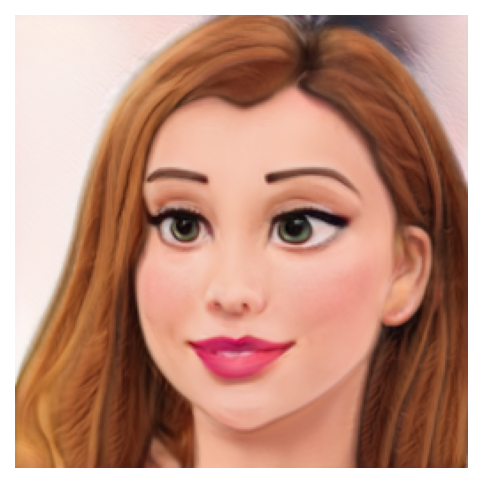

In [12]:
#@title Toonify input face using the reference disney face
#@markdown num_swap determines how many early layers to borrow from input image. This controls how much structure to borrow from input image.
num_swap =  6#@param {type:"slider", min:0, max:20, step:1}
#@markdown alpha controls the degree of toonification
alpha =  0.7#@param {type:"slider", min:0, max:1, step:0.1}


plt.rcParams['figure.dpi'] = 150 # default for me was 75

early_alpha = 0

with torch.no_grad():
    noise1 = [getattr(generator.noises, f'noise_{i}') for i in range(generator.num_layers)]
    noise2 = [getattr(generator2.noises, f'noise_{i}') for i in range(generator2.num_layers)]

    out1 = generator.input(latent1[0])
    out2 = generator2.input(latent2[0])
    out = (1-early_alpha)*out1 + early_alpha*out2
    
    out1, _ = generator.conv1(out, latent1[0], noise=noise1[0])
    out2, _ = generator2.conv1(out, latent2[0], noise=noise2[0])
    out = (1-early_alpha)*out1 + early_alpha*out2
#     out = out2

    skip1 = generator.to_rgb1(out, latent1[1])
    skip2 = generator2.to_rgb1(out, latent2[1])
    skip = (1-early_alpha)*skip1 + early_alpha*skip2

    i = 2
    for conv1_1, conv1_2, noise1_1, noise1_2, to_rgb1, conv2_1, conv2_2, noise2_1, noise2_2, to_rgb2 in zip(
        generator.convs[::2], generator.convs[1::2], noise1[1::2], noise1[2::2], generator.to_rgbs,
        generator2.convs[::2], generator2.convs[1::2], noise2[1::2], noise2[2::2], generator2.to_rgbs
    ):
    

        conv_alpha = early_alpha if i < num_swap else alpha
        out1, _ = conv1_1(out, latent1[i], noise=noise1_1)
        out2, _ = conv2_1(out, latent2[i], noise=noise2_1)
        out = (1-conv_alpha)*out1 + conv_alpha*out2
#         out = out1
        i += 1

        conv_alpha = early_alpha if i < num_swap else alpha
        out1, _ = conv1_2(out, latent1[i], noise=noise1_2)
        out2, _ = conv2_2(out, latent2[i], noise=noise2_2)
        out = (1-conv_alpha)*out1 + conv_alpha*out2
#         out = out1
        i += 1

        conv_alpha = early_alpha if i < num_swap else alpha
        skip1 = to_rgb1(out, latent1[i], skip)
        skip2 = to_rgb2(out, latent2[i], skip)
        skip = (1-conv_alpha)*skip1 + conv_alpha*skip2

        i += 1
    image = skip.clamp(-1,1)
    display_image(image)
